### LatticeKrig Dew Point Analysis (Examples)

This notebook provides visualizations for pressure analyses generated using LatticeKrig. Pressure analyses were created with MADIS dew point dewpoint observations available to the public (Public) and available to researchers (Full). Publicly accessible MADIS observations are provided in this repository within the data directory under Kriging. Additionally, pre-generated kriging analyses created from restricted MADIS (research) observations are also provided in the Kriging directory.

1. Import relevant python libraries and setup cartopy/colortables

2. Retrieve MADIS pressure analyses and prediction error. Subset analyses grids within a bounding box and mask analyes over water.

3. Visual comparison of MADIS dew point dewpoint analyses generated with publicly acessible observations (Public) and with observations available to researchers (Full).

4. Plot MADIS pressure analyses during a derecho event that impacted the Mid-Atlantic states in May, 2018.

In [1]:
### ---- (1) ---- ####
#Import python libraries
import os
import xarray as xr
import matplotlib
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import funcs
import sys
import colorcet as cc
from datetime import datetime,timedelta
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import colortables
from scipy import ndimage
from matplotlib.colors import LogNorm

#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

# Download/add state and coastline features for cartopy 
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Define function to add map data to matplotlib plot
def add_map(ax,clr,lw):
    ax.add_feature(states)
    ax.add_feature(BORDERS)
    ax.add_feature(land_50m)
    ax.add_feature(states,edgecolor=clr,lw=lw)
    ax.add_feature(LAKES, edgecolor=clr)

#Define function to add latitude/longitude grid lines to cartopy/matplotlib plot
def add_gridlines(ax,xl,yl,clr, fs):
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                      linewidth=0.25, color=clr, alpha=1, linestyle='--')

    gl.xlabels_bottom = xl
    gl.xlabels_top = False
    gl.ylabels_left = yl
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': clr}
    gl.ylabel_style = {'size': fs, 'color': clr}
    return gl

#Get Composite Reflectivity colormap from metpy
ctable1 = 'NWSStormClearReflectivity'
cmapp = cc.cm.rainbow_bgyrm_35_85_c71
norm, cmapp_radar = colortables.get_with_steps(ctable1, 244, 244)

#Increase width of notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Define date of analyses and observation type
date = '20180515_2035'
otyp = 'dewpoint'

#Set bounding boxes for analyses
minLng = -105.5; maxLng = -70.5; minLat = 28.5; maxLat = 48.5 #Full domain (Central - Eastern U.S.)
minLng2 = -83.0; maxLng2 = -70.5; minLat2 = 38.5; maxLat2= 45.0 #Sub-domain (Mid-Atlantic States)

#Define function to mask pressure analyses over water
def mask_grid(arr):
    arr = np.ma.masked_where(landsea==0,arr)
    return arr

#Read land/sea boolean grid
ds_land = xr.open_dataset('../data/Static/landsea.nc') 
ds_land = funcs.subset(ds_land,minLat,maxLat,minLng,maxLng) #Subset grid within bounding box
landsea = ds_land['LANDSEA'].values #Retrieve boolean
landsea = np.pad(landsea, ((0,1),(0,1)), 'edge') #Pad grid to fit analyses domain
ds_land.close() 

#Retreive composite reflectivity analyses during the 5-min analyses window
dsr = xr.open_dataset('../data/Radar/cref_'+date+'.nc')
dsr = funcs.subset(dsr,minLat,maxLat,minLng,maxLng) #Subset reflectivity analyses within the bounding box
rfl = dsr['REFL'].values #Retrieve composite reflectivity
dsr.close()

#Get output of MADIS kriging analyses performed in the R_LatticeKrig_example notebook
ds_madis_pub = xr.open_dataset('../data/Kriging/'+otyp+'_pub_'+date+'.nc')
#Retrieve publicly accessible observation data
mdwpt = ds_madis_pub[otyp].values 
mlats = ds_madis_pub['latitude'].values 
mlngs = ds_madis_pub['longitude'].values
ds_madis_pub.close()

#Retrieve MADIS kriging analyses generatred in R_LatticeKrig_example
ds_lk = xr.open_dataset('../data/Kriging/frkmadis_pub_'+otyp+'_'+date+'.nc')
#Retrieve pre-generated MADIS kriging analyses created using restricted MADIS (Research) observations
ds_lk2 = xr.open_dataset('../data/Kriging/frkmadis_'+otyp+'_'+date+'.nc')

#Mask dewpoint analyses over water
dwpt_pub_lk = mask_grid(ds_lk[otyp].values)
dwptvar_pub_lk = mask_grid(ds_lk[otyp+'_var'].values)

#Mask dewpoint uncertainty (prediction error) over water
dwpt_lk = mask_grid(ds_lk2[otyp].values)
dwptvar_lk = mask_grid(ds_lk2[otyp+'_var'].values)

#Retrieve latitude/longitude of analysis grid
ygrid = ds_lk['longitude'].values
xgrid = ds_lk['latitude'].values

#Create 2-d coordinate grid
X,Y = np.meshgrid(ygrid,xgrid)

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

Text(0.5, 0.98, '5-min Dew Point Analysis: 2035 UTC 15 May 2018')

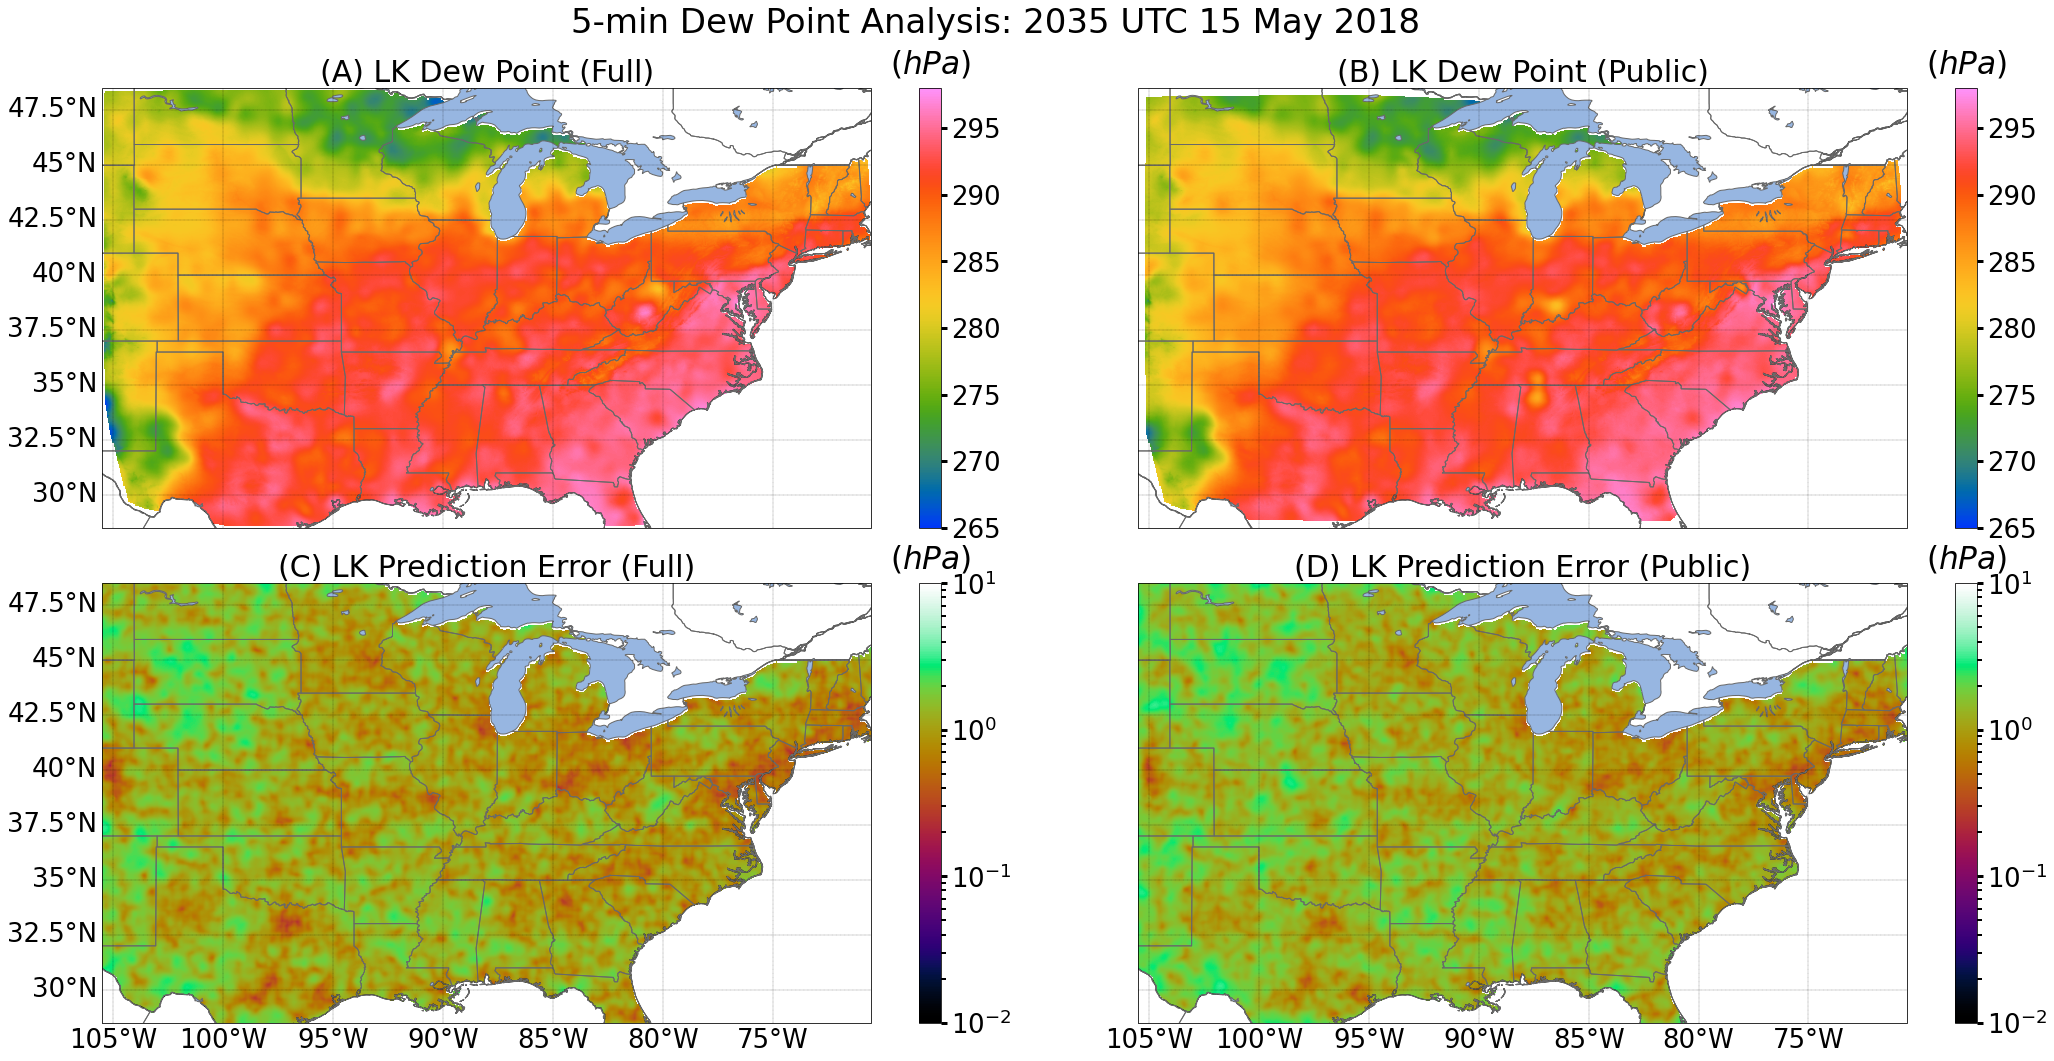

In [3]:
#---- (3) ----#
#Plot MADIS Pressure analyses generated with publicly acessible observations (Public) and with observations available to Researchers (Full)

#Initialize figure
fig =plt.figure(figsize=(30,15))
#Set base fontszie
matplotlib.rcParams.update({'font.size': 26})

#Set min/max bounds for pressure colorbar
mmin = round(np.nanmin(dwpt_lk)-0.5,0)
mmax = round(np.nanmax(dwpt_lk)+0.5,0)

#Subplot (A) - Plot pre-generated LatticeKrig pressure analyis created with MADIS Research observations
ax1 = plt.subplot(221,projection=crs.PlateCarree()) #Set projection
add_map(ax1,'dimgray',1) #Add States/borders
add_gridlines(ax1,False,True,'k',26) #Add grid lines and x/y labels        
im = ax1.imshow(dwpt_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=mmin,vmax=mmax) 
#Set grid bounds
ax1.set_xlim([minLng,maxLng]) 
ax1.set_ylim([minLat,maxLat])
ax1.set_title('(A) LK Dew Point (Full)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (B) - Plot LatticeKrig pressure analyis, created in R_LatticeKrig_example, with publicly available MADIS observations
ax2 = plt.subplot(222,projection=crs.PlateCarree())
add_map(ax2,'dimgray',1) #Add States/borders
add_gridlines(ax2,False,False,'k',26)  #Add grid lines and x/y labels              
im = ax2.imshow(dwpt_pub_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=mmin,vmax=mmax) 
#Set grid bounds
ax2.set_xlim([minLng,maxLng])
ax2.set_ylim([minLat,maxLat])
ax2.set_title('(B) LK Dew Point (Public)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)
maxx = np.nanmax(dwptvar_lk)

#Subplot (C) - Plot pre-generated LatticeKrig prediction error created with MADIS Research observations
ax3 = plt.subplot(223,projection=crs.PlateCarree())
add_map(ax3,'dimgray',1) #Add States/borders
add_gridlines(ax3,True,True,'k',26)  #Add grid lines and x/y labels      
im = ax3.imshow(dwptvar_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],norm=LogNorm(),cmap=cmr.chroma,vmin=0.01,vmax=10)
#Set grid bounds
ax3.set_xlim([minLng,maxLng])
ax3.set_ylim([minLat,maxLat])
ax3.set_title('(C) LK Prediction Error (Full)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (D) - Plot LatticeKrig prediction error estimate, created in R_LatticeKrig_example, with publicly available MADIS observations
ax4 = plt.subplot(224,projection=crs.PlateCarree())
add_map(ax4,'dimgray',1) #Add States/borders
add_gridlines(ax4,True,False,'k',26)  #Add grid lines and x/y labels      
im = ax4.imshow(dwptvar_pub_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],norm=LogNorm(),cmap=cmr.chroma,vmin=0.01,vmax=10)
#Set grid bounds
ax4.set_xlim([minLng,maxLng])
ax4.set_ylim([minLat,maxLat])
ax4.set_title('(D) LK Prediction Error (Public)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)
fig.canvas.draw()
plt.tight_layout()
#Adjust subplot to fit subplot title
plt.subplots_adjust(top=0.92)
#Display subplot title
plt.suptitle('5-min Dew Point Analysis: 2035 UTC 15 May 2018',verticalalignment='center',horizontalalignment='center',fontsize=34)

Text(0.5, 0.98, '5-min Dew Point Analysis: 2035 UTC 15 May 2018')

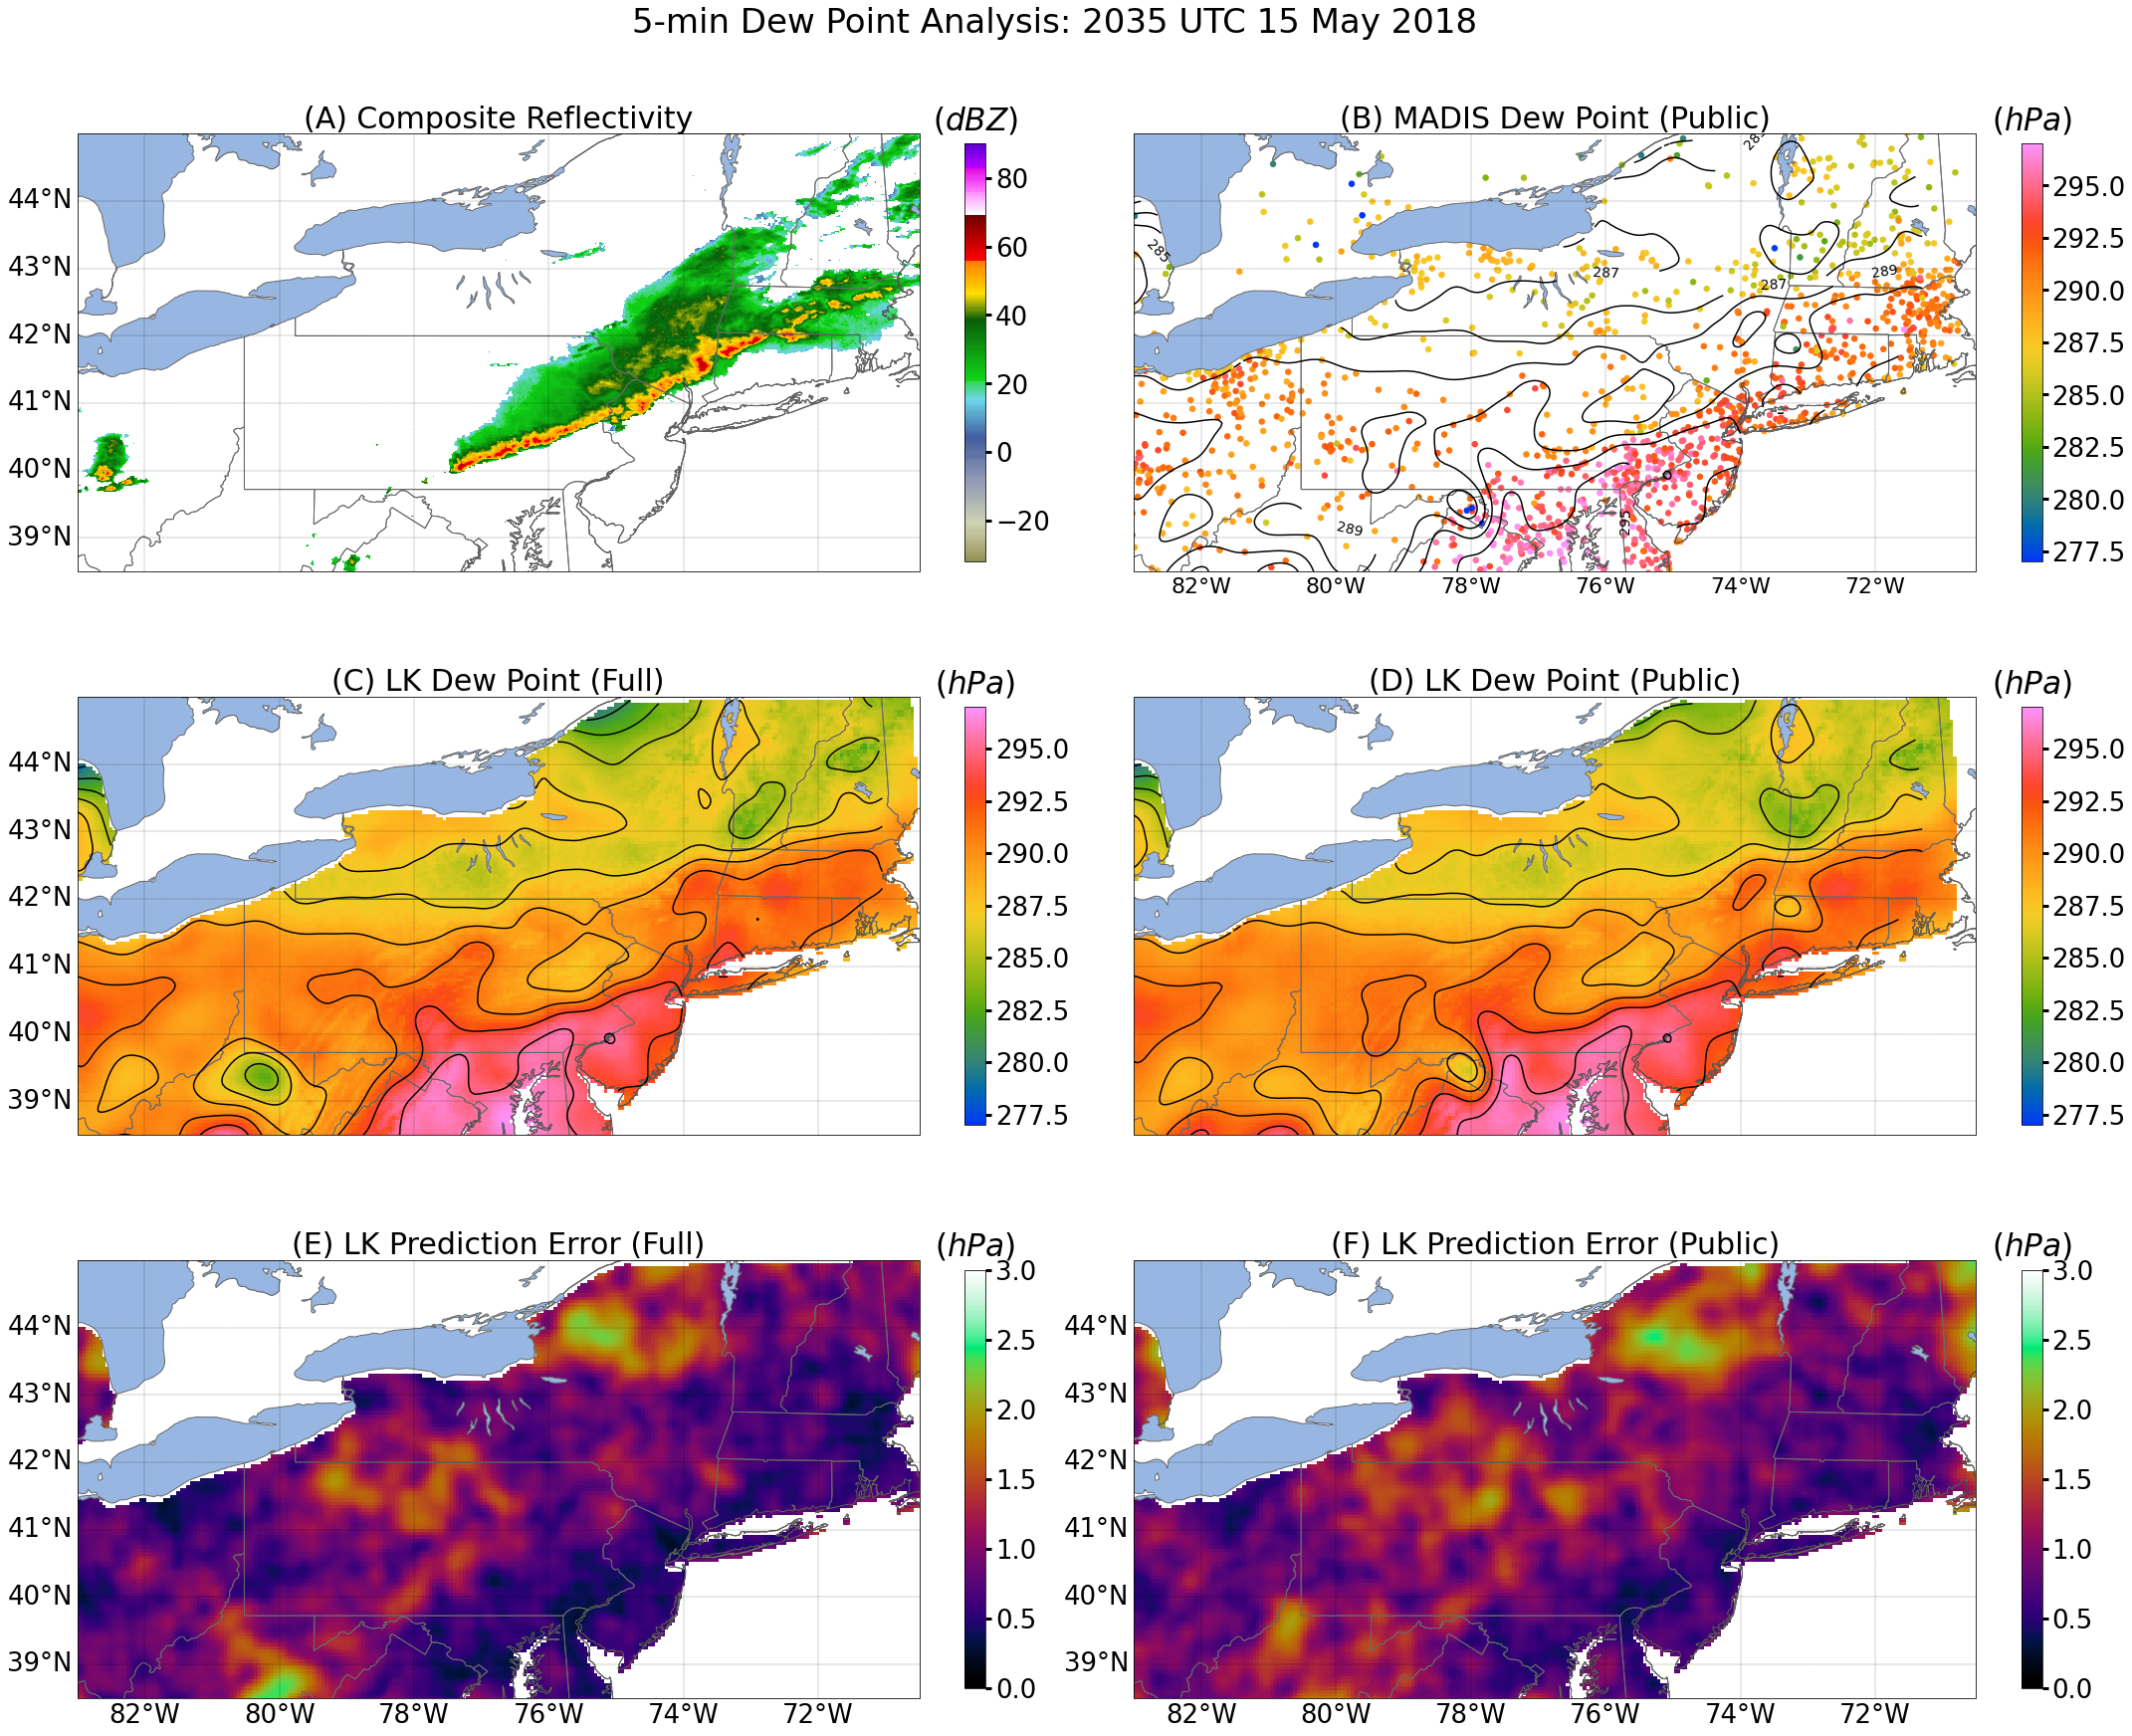

In [4]:
#---- (4) ----#
#Plot MADIS pressure analyses during a derecho event that impacted the mid-atlantic states on 15 May, 2018

#Initialize figure
fig =plt.figure(figsize=(30,25))
#Set base fontsize
matplotlib.rcParams.update({'font.size': 26})
#Preset pressure bounds for colorbar
#mmin = 1005; mmax = 1015

#Smooth dewpoint analyses for contour generation
dwpt_pub_lk_smooth = ndimage.gaussian_filter(dwpt_pub_lk,sigma=2.5)
dwpt_lk_smooth = ndimage.gaussian_filter(dwpt_lk,sigma=2.5)

mmin = 277
mmax = 297
#mmin = round(np.nanpercentile(dwpt_lk_smooth,2.5),0)
#mmax = round(np.nanpercentile(dwpt_lk_smooth,97.5),0)

#Subplot (A) - Plot composite reflectivity show the extent of the derecho across Pennsylvania, New Jersey, and New York
ax1 = plt.subplot(321,projection=crs.PlateCarree())
add_map(ax1,'dimgray',1) #Add States/borders
add_gridlines(ax1,False,True,'k',26)  #Add grid lines and x/y labels         
im = ax1.imshow(rfl,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_radar,vmin=-32,vmax=90)
#Set grid bounds
ax1.set_xlim([minLng2,maxLng2])
ax1.set_ylim([minLat2,maxLat2])
ax1.set_title('(A) Composite Reflectivity',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($dBZ$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (B) - Plot MADIS (Public) observations with pressure contours from the MADIS (Public) kriging analysis overlaid.
ax2 = plt.subplot(322,projection=crs.PlateCarree()) 
add_map(ax2,'dimgray',1) #Add States/borders
add_gridlines(ax2,True,False,'k',22) #Add grid lines and x/y labels       
im = ax2.scatter(mlngs,mlats,c=mdwpt,s=30,cmap=cmapp,vmin=mmin,vmax=mmax) #Plot MADIS point observations
CS = ax2.contour(X,Y,np.ma.masked_where(landsea==0,dwpt_pub_lk_smooth),levels=np.arange(mmin,mmax+2,2),colors='k',alpha=1) #Add contours from MADIS (Public) analysis
ax2.clabel(CS, CS.levels, inline=True, fmt="%1.f", fontsize=14, colors='k') #Label contours
#Set grid bounds
ax2.set_xlim([minLng2,maxLng2])
ax2.set_ylim([minLat2,maxLat2])
ax2.set_title('(B) MADIS Dew Point (Public)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (C) - Plot pre-generated LatticeKrig prediction error created with MADIS Research observations
ax3 = plt.subplot(323,projection=crs.PlateCarree())
add_map(ax3,'dimgray',1) #Add States/borders
add_gridlines(ax3,False,True,'k',26) #Add grid lines and x/y labels       
im = ax3.imshow(dwpt_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=mmin,vmax=mmax)
CS = ax3.contour(X,Y,np.ma.masked_where(landsea==0,dwpt_lk_smooth),levels=np.arange(mmin,mmax+2,2),colors='k',alpha=1)
#ax1.clabel(CS, CS.levels, inline=True, fmt="%1.f", fontsize=16, colors='k')
#Set grid bounds
ax3.set_xlim([minLng2,maxLng2])
ax3.set_ylim([minLat2,maxLat2])
ax3.set_title('(C) LK Dew Point (Full)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023)
cb.ax.set_title('($hPa$)',y=1.02)
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (D) - Plot LatticeKrig pressure analyis, created in R_LatticeKrig_example, with publicly available MADIS observations
ax4 = plt.subplot(324,projection=crs.PlateCarree())
add_map(ax4,'dimgray',1) #Add States/borders
add_gridlines(ax4,False,False,'k',26) #Add grid lines and x/y labels     
im = ax4.imshow(dwpt_pub_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=mmin,vmax=mmax)
CS = ax4.contour(X,Y,np.ma.masked_where(landsea==0,dwpt_pub_lk_smooth),levels=np.arange(mmin,mmax+2,2),colors='k') #,alpha=1)
#ax2.clabel(CS, CS.levels, inline=True, fmt="%1.f", fontsize=16, colors='k')
ax4.set_xlim([minLng2,maxLng2])
ax4.set_ylim([minLat2,maxLat2])
ax4.set_title('(D) LK Dew Point (Public)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (E) - Plot pre-generated LatticeKrig prediction error created with MADIS Research observations
ax5 = plt.subplot(325,projection=crs.PlateCarree())
add_map(ax5,'dimgray',1) #Add States/borders
add_gridlines(ax5,True,True,'k',26) #Add grid lines and x/y labels         
im = ax5.imshow(dwptvar_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.chroma,vmin=0,vmax=3)
ax5.set_xlim([minLng2,maxLng2])
ax5.set_ylim([minLat2,maxLat2])
ax5.set_title('(E) LK Prediction Error (Full)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

#Subplot (F) - Plot LatticeKrig prediction error estimate, created in R_LatticeKrig_example, with publicly available MADIS observations
ax6 = plt.subplot(326,projection=crs.PlateCarree())
add_map(ax6,'dimgray',1) #Add States/borders
add_gridlines(ax6,True,True,'k',26) #Add grid lines and x/y labels         
im = ax6.imshow(dwptvar_pub_lk,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.chroma,vmin=0,vmax=3)
ax6.set_xlim([minLng2,maxLng2])
ax6.set_ylim([minLat2,maxLat2])
ax6.set_title('(F) LK Prediction Error (Public)',fontsize=30)
cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
cb.ax.set_title('($hPa$)',y=1.02) #Set colorbar title
#Increase width of colorbar ticks
cb.ax.tick_params(which='minor',width=2,length=5)
cb.ax.tick_params(which='major',width=3,length=6)

fig.canvas.draw()
plt.tight_layout()
#Adjust subplot to fit subplot title
plt.subplots_adjust(top=0.94)
#Display subplot title
plt.suptitle('5-min Dew Point Analysis: 2035 UTC 15 May 2018',verticalalignment='center',horizontalalignment='center',fontsize=34)